## Model Selection & Interpretation

In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
# set filenames

filename = ('data/kenya_pre_processed_nlp.csv')

In [6]:
# read in kenya data

df = pd.read_csv(filename).set_index('LOAN_ID').drop(columns = 'Unnamed: 0')

In [7]:
#make sure we have what we expect.
df.head()

,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,STATUS
LOAN_ID,,,,
1799331,"['dinnah', 'year', 'age', 'proud', 'mother', '...","['buy', 'farm', 'input', 'seed', 'fertilizer',...",['parent'],1
1294719,"['resy', 'married', 'woman', 'blessed', 'kid',...","['purchase', 'chick', 'poultry', 'feed']","['animal', 'womanowned', 'business', 'voluntee...",1
1595847,"['lavenda', 'happily', 'married', 'blessed', '...","['add', 'stock', 'beauty', 'product', 'salon']","['user_favorite', 'parent', 'womanowned', 'bus...",0
1139606,"['hadija', 'kiva', 'borrower', 'describes', 'h...","['buy', 'stock', 'vegetable', 'flour', 'sugar'...","['repeat', 'borrower', 'womanowned', 'business']",1
1813411,"['purity', 'aged', 'lovely', 'mother', 'child'...","['purchase', 'highquality', 'seed', 'nutrientr...",['nan'],1


In [8]:
#check out the shape
df.shape

(50011, 4)

### Set up Variables

In [9]:
#set up X and y

X = df['DESCRIPTION_TRANSLATED']
y = df['STATUS']

In [10]:
#check for baseline
y.value_counts(normalize=True)

1    0.779688
0    0.220312
Name: STATUS, dtype: float64

In [11]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

### Visualize Top Occurring Words/Phrases with Tuned Parameters

In [12]:
tvec = TfidfVectorizer(ngram_range=(1,2), max_features=6_000)

In [13]:
tvec.fit(X_train)
X_train_tvec = tvec.transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [14]:
X_train_tvec.shape

(40008, 6000)

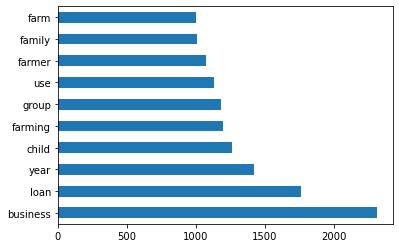

In [15]:
# top-occurring words
X_train_df_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                         columns=tvec.get_feature_names())

X_train_df_tvec.sum().sort_values(ascending = False).head(10).plot(kind='barh');

In [16]:
# top-occurring words
success_df = pd.DataFrame(tvec.fit_transform(df['DESCRIPTION_TRANSLATED'][df['STATUS'] == 1]).todense(),
                         columns=tvec.get_feature_names())

expired_df = pd.DataFrame(tvec.fit_transform(df['DESCRIPTION_TRANSLATED'][df['STATUS'] == 0]).todense(),
                         columns=tvec.get_feature_names())

In [17]:
top_success = success_df.sum().sort_values(ascending = False).head(15)
top_expired = expired_df.sum().sort_values(ascending = False).head(15)

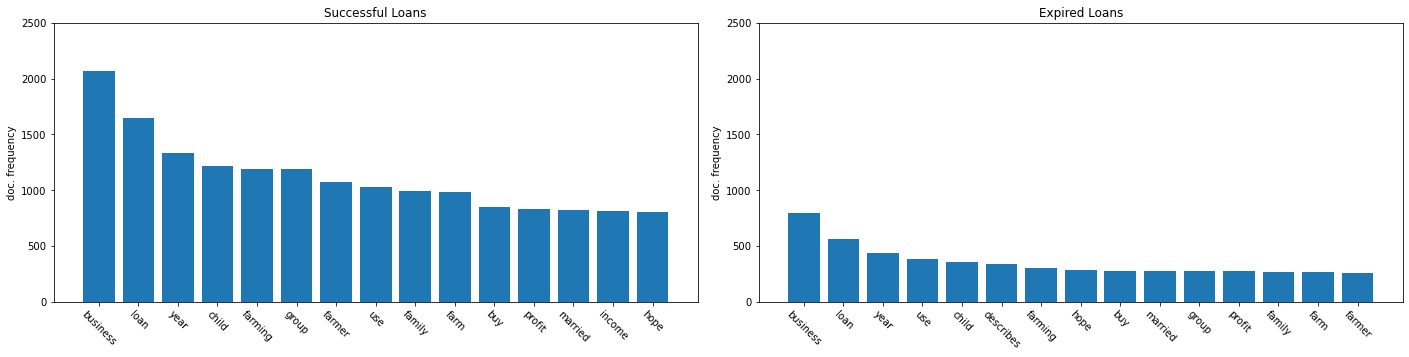

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5));
fig.tight_layout(pad =3)

ax1.bar(top_success.index, top_success);
ax1.set(title='Successful Loans', ylabel='doc. frequency');
ax1.tick_params('x', labelrotation=-45); 
ax1.set_ylim([0, 2500]);
ax2.bar(top_expired.index, top_expired);
ax2.set(title='Expired Loans', ylabel = 'doc. frequency');
ax2.tick_params('x', labelrotation=-45); 
ax2.set_ylim([0, 2500]);


# FINAL MODEL

-
Do final model 
plot confusion matrix
classification report
explore coefficients
top occuring phrases with ngram range

In [19]:
logreg = LogisticRegression(C=1)

In [20]:
logreg.fit(X_train_tvec, y_train)

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [21]:
training_score = logreg.score(X_train_tvec, y_train)
testing_score = logreg.score(X_test_tvec, y_test)
cv_score = cross_val_score(logreg, X_train_tvec, y_train, cv=3).mean()
print(f'Training Score is:  {training_score}')
print(f'Testing Score is:  {testing_score}')
print(f'Cross-val score is: {cv_score}.')

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Training Score is:  0.8140371925614877
Testing Score is:  0.803558932320304
Cross-val score is: 0.7996900619876025.


/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


|  	| Value 	|
|-	|-	|
| Training Score 	| 0.8140371925614877 	|
| Testing Score 	| 0.803558932320304 	|
| Cross-val score 	| 0.7996900619876025 	|
| Model Params 	| C = 1, ngram_range = (1,2), max_features = 6_000  	|

In [22]:
# Get Predictions

preds = logreg.predict(X_test_tvec)

# plot confusion matrix
cm = confusion_matrix(y_test, preds)

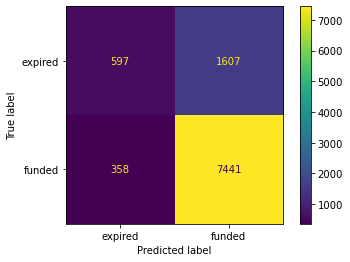

In [23]:
ConfusionMatrixDisplay(cm, display_labels = ['expired', 'funded']).plot();

In [24]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.63      0.27      0.38      2204
           1       0.82      0.95      0.88      7799

    accuracy                           0.80     10003
   macro avg       0.72      0.61      0.63     10003
weighted avg       0.78      0.80      0.77     10003



The model is much better at predicting successful loans than it is at expired loans. 

### Exploring Coefficients

In [31]:
#explore words and their coefficients 
coef_dict = {'coefficient': logreg.coef_[0], 'words': tvec.get_feature_names()}
coef_df = pd.DataFrame(coef_dict)
coef_df.sort_values(by = 'coefficient', ascending=False, inplace=True)

In [32]:
#check out the strongest positively correlated words 
coef_df.head(10)

,coefficient,words
5849,3.308462,wife farmer
5183,3.282797,simple house
2402,3.108813,grows sell
5178,3.022905,significant improvement
5850,2.668986,wife run
5807,2.287940,water
5182,2.138017,simple
3902,2.099856,mpesa shop
681,1.962727,capital expand
4877,1.927301,rural community


In [33]:
#check out the strongest negatively correlated words 
coef_df.tail(10)

,coefficient,words
2183,-2.047216,future
4567,-2.122257,pull poverty
2187,-2.157397,future big
5285,-2.165366,stable family
5156,-2.231648,shop hope
2024,-2.280516,ferry
327,-2.318794,basic need
3080,-2.397770,kenyan farmer
3926,-2.467690,near
3667,-3.132816,marketing


### Exploring Where and When Classification Errors Happen

In [25]:
# Create DataFrame with column for true values.
results = pd.DataFrame(y_test)

#add in predictions
results['preds'] = (logreg.predict(X_test_tvec))
results.head()

,STATUS,preds
LOAN_ID,,
1226723,0,1
1419240,1,1
1841898,1,1
1076280,1,0
1009880,0,1


In [26]:
# Find all indices where predicted and true results 
# aren't the same, then save in an array.

row_ids = results[results['STATUS'] != results['preds']].index
print(row_ids[0:15])

Int64Index([1226723, 1076280, 1009880, 1396076, 1565193, 1651852, 1544429,
            1859127, 1092472,  828202, 1011734, 1740174, 1143012,  825434,
            1564254],
           dtype='int64', name='LOAN_ID')


In [27]:
#Create a dataframe of the misclassified descriptions  
misclassified = df.loc[row_ids]

In [28]:
misclassified.shape

(1965, 4)

There are 1965 total misclassified loans.

In [29]:
misclassified.head()

,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,STATUS
LOAN_ID,,,,
1226723,"['small', 'scale', 'farmer', 'given', 'access'...","['laban', 'buy', 'farm', 'implement', 'highqua...",['parent'],0
1076280,"['maureen', 'year', 'old', 'married', 'child',...","['add', 'stock', 'stall']","['womanowned', 'business', 'parent']",1
1009880,"['hello', 'lender', 'evans', 'smiling', 'proud...","['buy', 'cereal', 'sell']","['supporting', 'family']",0
1396076,"['lina', 'woman', 'year', 'age', 'passionate',...","['pay', 'farm', 'input', 'hire', 'labor', 'gro...","['elderly', 'womanowned', 'business', 'job', '...",0
1565193,"['suan', 'married', 'woman', 'child', 'describ...","['purchase', 'fruit', 'result', 'increasing', ...","['womanowned', 'business', 'repeat', 'borrower...",0


In [30]:
misclassified['STATUS'].value_counts(normalize=True)

0    0.817812
1    0.182188
Name: STATUS, dtype: float64

This model misclassifies expired loans more often than it does successful, as evidenced by the over-representation of expired loans in "misclassified" relative to its prevalence in the dataset overall ('df').

In [34]:
#create a dictionary with the probability that a loan will be funded
predict_proba_dict = {'probability (success)' : logreg.predict_proba(X_test_tvec)[:,1],
                     'prediction' : logreg.predict(X_test_tvec),
                     'actual' : y_test,
                     'post_text' : X_test}

In [35]:
#turn it into a dataframe 
predict_proba_df = pd.DataFrame(predict_proba_dict)

#### False Negatives

In [36]:
#look at misclassified loans with the lowest probability of being funded
predict_proba_df.query('prediction != actual').sort_values(by='probability (success)').head(10)

,probability (success),prediction,actual,post_text
LOAN_ID,,,,
1710632,0.057981,0,1,"['evans', 'married', 'man', 'child', 'describe..."
1598391,0.137942,0,1,"['stanley', 'married', 'man', 'child', 'descri..."
960563,0.145749,0,1,"['william', 'yearold', 'retail', 'shop', 'prop..."
1701564,0.181157,0,1,"['zaina', 'yearold', 'married', 'woman', 'chil..."
1620179,0.199417,0,1,"['joshua', 'married', 'man', 'child', 'describ..."
1377715,0.201978,0,1,"['richard', 'married', 'man', 'describes', 'am..."
1467239,0.213950,0,1,"['samuel', 'married', 'man', 'child', 'describ..."
1192044,0.216643,0,1,"['daniel', 'year', 'old', 'married', 'blessed'..."
953029,0.219719,0,1,"['paul', 'married', 'man', 'child', 'asked', '..."


In [95]:
fns = predict_proba_df.query('prediction != actual').sort_values(by='probability (success)').head(10).index

#### False Positives

In [37]:
#look at misclassified loans with the highest probability of being funded
predict_proba_df.query('prediction != actual').sort_values(by='probability (success)').tail(10)

,probability (success),prediction,actual,post_text
LOAN_ID,,,,
1393293,0.957913,1,0,"['lady', 'raising', 'hand', 'photo', 'salome',..."
1686981,0.958089,1,0,"['lilian', 'hardworking', 'woman', 'defied', '..."
1667373,0.960412,1,0,"['carren', 'single', 'mother', 'adorable', 'ch..."
1093975,0.961062,1,0,"['pahe', 'married', 'woman', 'seven', 'kid', '..."
1094379,0.961886,1,0,"['rosemary', 'married', 'woman', 'child', 'att..."
1011121,0.961934,1,0,"['person', 'raising', 'hand', 'photo', 'joshua..."
1575297,0.962011,1,0,"['irene', 'farmer', 'remote', 'town', 'nandihi..."
1682924,0.963137,1,0,"['priscah', 'single', 'mom', 'known', 'custome..."
910596,0.966340,1,0,"['mike', 'year', 'old', 'married', 'life', 'wi..."


In [96]:
fps = predict_proba_df.query('prediction != actual').sort_values(by='probability (success)').tail(10).index

#### Explore Complete Text of Misclassified Loan Desciptions

In [88]:
#load in the data 
filename = ('data/kenya_cleaned_nlp.csv')

In [42]:
df = pd.read_csv(filename).set_index('LOAN_ID')

In [79]:
desc_list = [df['DESCRIPTION_TRANSLATED'][i] for i in df.index if  i in  misclassified.index]
index_list = [i for i in df.index if i in misclassified.index]
status_list = [df['STATUS'][i] for i in df.index if  i in  misclassified.index]

In [83]:
misclassified_df = pd.DataFrame(list(zip(index_list, desc_list, status_list)),columns=['LOAN_ID','DESCRIPTION_TRANSLATED', 'TRUE_STATUS']).set_index('LOAN_ID')

In [84]:
misclassified_df.head()

,DESCRIPTION_TRANSLATED,TRUE_STATUS
LOAN_ID,,
909048,Constantine is a smallholder farmer residing i...,0
1038206,"Featured in the above picture is Alfred, who h...",0
1605480,Emmanuel is a 28-year-old married man. He has ...,1
1236109,Victor is in his second year of his studies at...,0
1736095,Margaret (51) has always emerged victorious de...,0


#### False Negatives

In [105]:
fn_df = pd.DataFrame(misclassified_df['DESCRIPTION_TRANSLATED'][fns])
for i in fn_df['DESCRIPTION_TRANSLATED']:
    print(i)
    print(" ")

Evans is a married man.  He has one child.  He describes himself as honest and ambitious.  He operates a retail business where he sells clothes.  He has been involved in this business for over six years.  His business is located in a good area, and his primary customers are locals from Nakuru, Kenya.  He describes his biggest business challenge as inadequate working capital. <br /><br />He will use the KES 30,000 loan to purchase additional stock of clothes for more sales.  His business goal is to have a bigger boutique within five years.  He hopes that in the future, he will be financially stable. This is his fifth loan with SMEP Microfinance Bank.  His previous loans were repaid successfully. He will use the anticipated profits to buy more stock of clothes.
 
Stanley is a married man. He has 3 children. He describes himself to be honest. He operates a m-pesa shop where he provides money transfer services. He has been involved in this business for 6 years. His business is located in a

#### False Positives

In [104]:
fp_df = pd.DataFrame(misclassified_df['DESCRIPTION_TRANSLATED'][fps])
for i in fp_df['DESCRIPTION_TRANSLATED']:
    print(i)
    print(" ")

The lady raising her hand in the photo is Salome. She is 52 years old, married, and the mother of three children. She is a member of Rwema Shg Group, which joined Hand in Hand Eastern Africa in the year 2016, and has benefited from enterprise development and financial management training. <br /><br />Salome does goat farming. She is borrowing a Kiva loan to buy more goats for resale. She hopes this will meet her customers' demands, hence increasing her income. She will therefore use the anticipated income to provide food and clothing for her family.<br /><br />She is grateful to Kiva and its lenders for the financial support and promises to repay promptly.
 
Lilian is a hardworking woman. She has defied the common thinking among most Kenyans that having proper learning and being born into a wealthy home are the only ways to become successful in life. She is a humble mother of lovely children. Her primary source of income is milk, and she plants different varieties of food crops. <br />